# cifar100 데이터셋 학습 (to do)

CIFAR-100 데이터셋은 총 100개의 label로 이루어진 이미지 분류를 위한 데이터셋이다.

각각의 레이블마다 32×32 크기 이미지인 50,000개의 training 데이터셋, 10,000개의 test 데이터셋이 존재하고, 결과적으로 총 60,000개의 32×32 크기의 이미지로 데이터셋이 구성되어 있다.

In [5]:
import tensorflow as tf
 
 
 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


2 Physical GPUs, 2 Logical GPUs


## (1) 데이터셋 준비

In [6]:
from keras.utils import np_utils
from keras import datasets
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
(x_train, y_train), (x_test, y_test) = datasets.cifar100.load_data()
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


label :  [19]


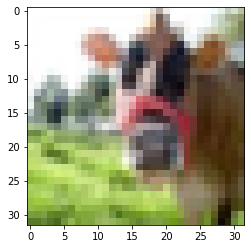

In [8]:
print('label : ',y_train[0])
plt.imshow(x_train[0])

In [9]:
x_train = x_train / 255.0
x_test = x_test / 255.0
x_train_gray = np.dot(x_train[:,:,:,:3], [0.299, 0.587, 0.114])
x_test_gray = np.dot(x_test[:,:,:,:3], [0.299, 0.587, 0.114])

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

x_train_gray = x_train_gray.reshape(-1,32,32,1)
x_test_gray = x_test_gray.reshape(-1,32,32,1)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 100)
(10000, 32, 32, 3) (10000, 100)


## (2) 모델링

In [12]:
np.random.seed(451)
import datetime
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers import BatchNormalization, MaxPooling2D
from keras.layers.core import Dense,Activation,Dropout,Flatten
from keras.utils import np_utils
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
from keras.layers import Flatten, Activation, Conv2D, MaxPool2D, AvgPool2D, Dense, Dropout, BatchNormalization, Input, MaxPooling2D, Flatten, Activation, Conv2D, AvgPool2D, Dense, Dropout, concatenate, AveragePooling2D
from keras.optimizers import Adam, SGD
from keras.models import Sequential
import keras.backend as K
from keras.regularizers import l1,l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.models import model_from_json, Model

def build_tower(input_layer, features_nr, shape, tower_nr, 
                dropout=False, normalization=False, regularization="l2", dropout_ratio=0.25):
    #3x3 kernel tower
    tower = Conv2D(features_nr, (1,1), padding='same', activation='relu', 
                     kernel_regularizer=regularization, name='tower_%d_%dx%da'%(tower_nr, shape[0], shape[1]))(input_layer)
    tower = Conv2D(features_nr*2, shape, padding='same', activation='relu',
                     kernel_regularizer=regularization, name='tower_%d_%dx%db'%(tower_nr, shape[0], shape[1]))(tower)
    #condidional dropout/normalization
    if dropout:
        tower = Dropout(dropout_ratio, name='tower_%d_%dx%ddrop'%(tower_nr, shape[0], shape[1]))(tower)
    if normalization:
        tower = BatchNormalization(name='tower_%d_%dx%dnorm'%(tower_nr, shape[0], shape[1]))(tower)
        
    return tower

def build_simple_tower(input_layer, features_nr, shape, tower_nr, 
                dropout=False, normalization=False, regularization="l2", dropout_ratio=0.25):
    #3x3 kernel tower
    tower = Conv2D(features_nr, shape, padding='same', activation='relu',
                     kernel_regularizer=regularization, 
                   name='tower_simple_%d_%dx%db'%(tower_nr, shape[0], shape[1]))(input_layer)
    #condidional dropout/normalization
    if dropout:
        tower = Dropout(dropout_ratio, name='tower_%d_%dx%ddrop'%(tower_nr, shape[0], shape[1]))(tower)
    if normalization:
        tower = BatchNormalization(name='tower_%d_%dx%dnorm'%(tower_nr, shape[0], shape[1]))(tower)
        
    return tower

def build_tower_subsample(input_layer, features_nr, shape, tower_nr, 
                          dropout=False, normalization=False, regularization='l2', dropout_ratio=0.25):
    tower = build_tower(input_layer, features_nr, shape, tower_nr, 
                        dropout, normalization, regularization, dropout_ratio)
    pool = MaxPooling2D((2,2), padding='same', name='tower_%d_2x2subsample'%(tower_nr))(tower)

    return pool

def build_simple_tower_subsample(input_layer, features_nr, shape, tower_nr, 
                          dropout=False, normalization=False, regularization='l2', dropout_ratio=0.25):
    tower = build_simple_tower(input_layer, features_nr, shape, tower_nr, 
                        dropout, normalization, regularization, dropout_ratio)
    pool = MaxPooling2D((2,2), padding='same', name='tower_%d_2x2subsample'%(tower_nr))(tower)

    return pool

def build_dense(input_layer, neurons_nr, dense_nr, 
                dropout=False, normalization=False, regularization='l2', dropout_ratio=0.5):
    dense = Dense(neurons_nr, kernel_regularizer=regularization, 
                  name='dense_%d_%d'%(dense_nr, neurons_nr))(input_layer)
    
    if dropout:
        dense = Dropout(dropout_ratio, name='dense_%d_%ddrop'%(dense_nr, neurons_nr))(dense)
    if normalization:
        dense = BatchNormalization(name='dense_%d_%dnorm'%(dense_nr, neurons_nr))(dense)
    
    return dense

def build_inception_module(input_layer, features_nr, module_nr, 
                           dropout=False, normalization=False, regularization='l2', dropout_ratio=0.2):  
    #feature_nr is an array we'll use to build our layers
    #data is in the form: [1x1, 3x3 reduce, 3x3, 5x5 reduce, 5x5, pool proj]
  
    inception_1x1 = Conv2D(features_nr[0],1,1,padding='same',activation='relu',name='inception_%d_/1x1'%(module_nr))(input_layer)
    
    inception_3x3_reduce = Conv2D(features_nr[1],1,1,padding='same',activation='relu',name='inception_%d_/3x3_reduce'%(module_nr))(input_layer)
    
    inception_3x3 = Conv2D(features_nr[2],3,3,padding='same',activation='relu',name='inception_%d_/3x3'%(module_nr))(inception_3x3_reduce)
    
    inception_5x5_reduce = Conv2D(features_nr[3],1,1,padding='same',activation='relu',name='inception_%d_/5x5_reduce'%(module_nr))(input_layer)
    
    inception_5x5 = Conv2D(features_nr[4],5,5,padding='same',activation='relu',name='inception_%d_/5x5'%(module_nr))(inception_5x5_reduce)
    
    inception_pool = MaxPooling2D(pool_size=(3,3),strides=(1,1),padding='same',name='inception_%d_/pool'%(module_nr))(input_layer)
    
    inception_pool_proj = Conv2D(features_nr[5],1,1,padding='same',activation='relu',name='inception_%d_/pool_proj'%(module_nr))(inception_pool)
    
    inception_output = concatenate([inception_1x1,inception_3x3,inception_5x5,inception_pool_proj],axis=3,name='inception_%d_/output'%(module_nr))

    if dropout:
        inception_output = Dropout(dropout_ratio, name='inception_%d_/output_drop'%(module_nr))(inception_output)
    if normalization:
        inception_output = BatchNormalization(name='inception_%d_/output_norm'%(module_nr))(inception_output)

    pooled = MaxPooling2D((2,2), padding='same', name='inception_%d_2x2subsample'%(module_nr))(inception_output)
    
    return pooled
    
    
use_norm = True
lrate = 0.001

input_img = Input(shape = (32, 32, 3), name='input')

inception_1 = build_inception_module(input_img, [64,96,128,16,32,32], 1, False, use_norm)

inception_2 = build_inception_module(inception_1, [128,128,192,32,96,64], 2, False, use_norm)

inception_3 = build_inception_module(inception_2, [192,96,208,16,48,64], 3, False, use_norm)

inception_4 = build_inception_module(inception_3, [160, 112, 224, 24, 64, 64], 4, False, use_norm)

flat_pool = AveragePooling2D(pool_size=(2, 2), padding='valid')(inception_4)

flat = Flatten()(flat_pool)


dense_5 = build_dense(flat, 128, 1, True, use_norm)

dense_6 = build_dense(dense_5, 64, 2, True, use_norm)

out = Dense(100, activation='softmax')(dense_6)

model = Model(inputs = input_img, outputs = out)

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 32, 32, 64), (None, 11, 11, 128), (None, 7, 7, 32), (None, 32, 32, 32)]

## (3) 모델의 학습과정 설정

In [7]:
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        2

## (4) 모델 학습시키기

In [9]:
history = model.fit(X_train,Y_train,batch_size=128, epochs=100,verbose=1)

Epoch 1/100
391/391 [==============================] - 73s 187ms/step - loss: 6.9348 - accuracy: 0.0264
Epoch 2/100
391/391 [==============================] - 16s 42ms/step - loss: 6.1647 - accuracy: 0.0426
Epoch 3/100
391/391 [==============================] - 16s 42ms/step - loss: 5.9074 - accuracy: 0.0504
Epoch 4/100
391/391 [==============================] - 17s 42ms/step - loss: 5.6931 - accuracy: 0.0600
Epoch 5/100
391/391 [==============================] - 17s 42ms/step - loss: 5.4950 - accuracy: 0.0720
Epoch 6/100
391/391 [==============================] - 17s 42ms/step - loss: 5.2994 - accuracy: 0.0843
Epoch 7/100
391/391 [==============================] - 17s 42ms/step - loss: 5.1121 - accuracy: 0.0985
Epoch 8/100
391/391 [==============================] - 17s 42ms/step - loss: 4.9314 - accuracy: 0.1128
Epoch 9/100
391/391 [==============================] - 17s 42ms/step - loss: 4.7676 - accuracy: 0.1277
Epoch 10/100
391/391 [==============================] - 17s 42ms/step - 

## (5) 모델 평가하기

In [12]:
result= model.evaluate(X_test, Y_test, batch_size=20)
print('loss : ',result[1]*100,"%")

500/500 [==============================] - 4s 8ms/step - loss: 3.4533 - accuracy: 0.6115
loss :  61.15000247955322 %
